In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from copy import deepcopy
from pandeia.engine.calc_utils import build_default_calc, build_default_source
from pandeia.engine.perform_calculation import perform_calculation
from webbpsf import roman

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, psf

In [2]:
array_dir = os.path.join(array_dir, 'sample_skypy_lens')
pickle_dir = os.path.join(pickle_dir, 'pyhalo')

# Generate images with various PSFs

In [3]:
lens = SampleStrongLens()

num_pix = 45
side = 4.95
band = 'f184'

## Grab default substructure

In [4]:
# add CDM subhalos; NB same subhalo population for all
lens.add_subhalos(*pyhalo.unpickle_subhalos(os.path.join(pickle_dir, 'cdm_subhalos_tuple')))

## No PSF

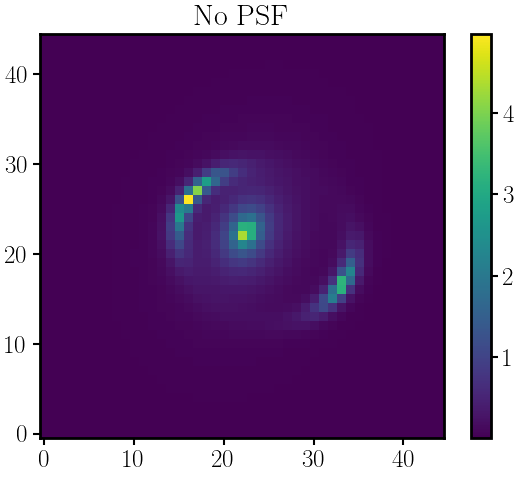

(45, 45)


In [5]:
no_psf_lens = deepcopy(lens)

kwargs_psf_none = {'psf_type': 'NONE'}

no_psf = no_psf_lens.get_array(num_pix=num_pix, kwargs_psf=kwargs_psf_none, side=side)

plot.plot(title='No PSF',
          array=no_psf,
          colorbar=True)

np.save(os.path.join(array_dir, 'no_psf.npy'), no_psf)

print(no_psf.shape)

## Gaussian PSF

I'm getting the PSF FWHM values from [here](https://roman.gsfc.nasa.gov/science/WFI_technical.html). From that webpage: "Note: PSF FWHM in arcseconds simulated at the center of the center pixel of a detector near the center of the WFI FOV using an input spectrum for a K0V type star."

In [6]:
psf_fwhm = {
    'f062': 0.058,
    'f087': 0.073,
    'f106': 0.087,
    'f129': 0.105,
    'f158': 0.127,
    'f184': 0.151,
    'f213': 0.175,
    'f146': 0.105
}

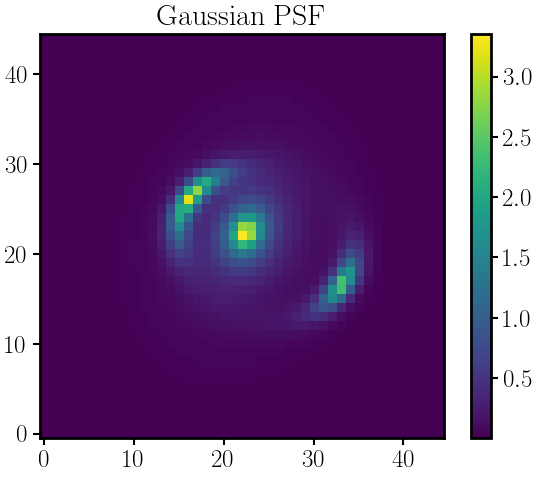

(45, 45)


In [7]:
gaussian_psf_lens = deepcopy(lens)

kwargs_psf_gaussian = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm.get(band)}

gaussian_psf = gaussian_psf_lens.get_array(num_pix=num_pix, kwargs_psf=kwargs_psf_gaussian, side=side)

plot.plot(title='Gaussian PSF',
          array=gaussian_psf,
          colorbar=True)

np.save(os.path.join(array_dir, 'gaussian_psf.npy'), gaussian_psf)

print(gaussian_psf.shape)

## WebbPSF

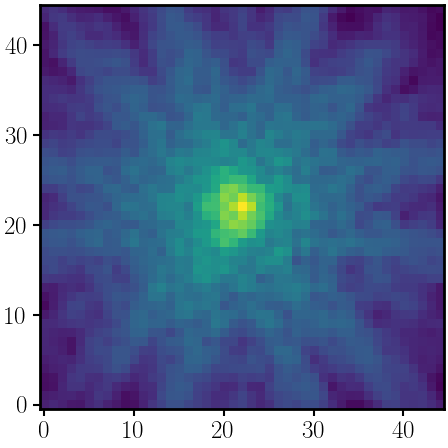

In [8]:
wfi = roman.WFI()
wfi.filter = 'F184'
wfi.detector = 'SCA01'
wfi.detector_position = (2048, 2048)
calc_psf = wfi.calc_psf(oversample=5)
kernel = psf.get_kernel_from_calc_psf(calc_psf)

plt.imshow(np.log10(kernel))

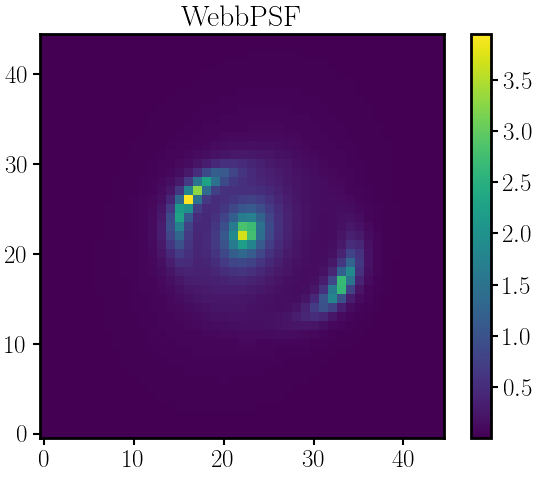

(45, 45)


In [9]:
webbpsf_lens = deepcopy(lens)

kwargs_webbpsf = {
    'psf_type': 'PIXEL',
    'kernel_point_source': kernel,
    'point_source_supersampling_factor': 5
    }

webbpsf_psf = webbpsf_lens.get_array(num_pix=num_pix, kwargs_psf=kwargs_webbpsf, side=side)

plot.plot(title='WebbPSF',
          array=webbpsf_psf,
          colorbar=True)

np.save(os.path.join(array_dir, 'webbpsf.npy'), webbpsf_psf)

print(webbpsf_psf.shape)

# Plot

In [10]:
no_psf = np.load(os.path.join(array_dir, 'no_psf.npy'))
gaussian_psf = np.load(os.path.join(array_dir, 'gaussian_psf.npy'))
pandeia = np.load(os.path.join(array_dir, 'webbpsf.npy'))

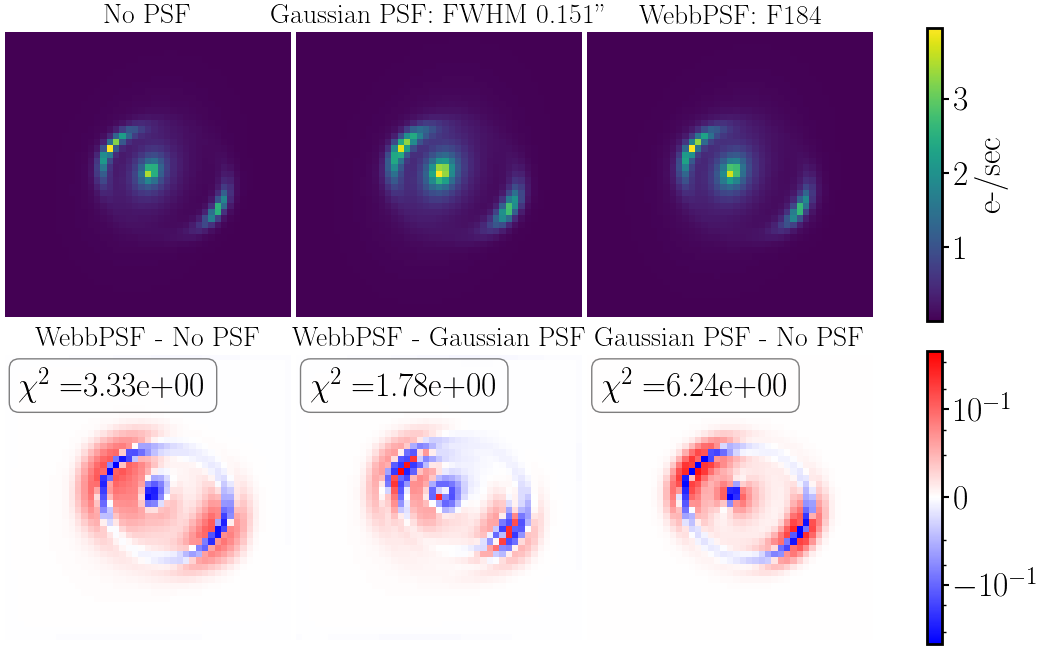

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 8), gridspec_kw={'hspace': 0.1, 'wspace': 0.02})

fontsize = 24
matplotlib.rcParams.update({'font.size': fontsize})

array_list = [no_psf, gaussian_psf, pandeia]
title_list = ['No PSF', f'Gaussian PSF: FWHM {psf_fwhm.get(band)}"', 'WebbPSF: F184']

for i, array in enumerate(array_list):
    axis_1 = ax[0][i].imshow((array), cmap='viridis')
    ax[0][i].set_title(title_list[i], fontsize=20)
    ax[0][i].set_axis_off()

cbar = fig.colorbar(axis_1, ax=ax[0])
cbar.set_label('e-/sec', rotation=90)

array_list = [pandeia - no_psf, pandeia - gaussian_psf, gaussian_psf - no_psf]
title_list = ['WebbPSF - No PSF', 'WebbPSF - Gaussian PSF', 'Gaussian PSF - No PSF']

# compute mean chi square
chi_square_list = []
chi_square_list.append(stats.chi_square(no_psf, pandeia))
chi_square_list.append(stats.chi_square(gaussian_psf, pandeia))
chi_square_list.append(stats.chi_square(gaussian_psf, no_psf))
chi_square_list = ['$\chi^2 = $' + '{:.2e}'.format(i) for i in chi_square_list]

norm = plot_util.get_norm(array_list, linear_width=0.01)

for i, array in enumerate(array_list):
    axis_2 = ax[1][i].imshow(array, cmap='bwr', norm=norm)
    ax[1][i].set_title(title_list[i], fontsize=20)
    ax[1][i].set_axis_off()

overplot.text_boxes(ax[1], chi_square_list, fontsize=fontsize)

cbar_residuals = fig.colorbar(axis_2, ax=ax[1], ticks=[-1, -10** -1, 0, 10 ** -1, 1])
# cbar_residuals.set_label('e-/sec', rotation=90)

plt.savefig(os.path.join(figure_dir, 'psf_compare.png'))
plt.show()